# Fast injection generation

In this notebook, we will generate fast injections of binary black hole coalescences according to the simplified prescription described in [this paper](https://ui.adsabs.harvard.edu/abs/2024ApJ...962..169E).


In [1]:
import sys
sys.path.append('..')
from pprint import pprint

import GWDALI as gwdali
from corner import corner
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from src.gw.detector import *
from src.gw.event import GWEvent
from src.gw.waveform import TaylorF2
from src.gw.gwdali import GWDALIDetectors
from src.gw.utils import network_snr
from src.inference.population import MadauDickinsonRedshiftPrior
from src.utils.math import sample_from_func
from src.utils.cosmology import flat_cosmology, luminosity_distance

The first step is to generate source-frame quantities $(m_1^s, m_2^s, z)$ from a given distribution. We choose the following priors:

\begin{align}
p(z|\alpha, \beta\, z_p) &\propto \frac{(1+z)^\alpha}{1 + \left (\frac{1 + z}{1 + z_p} \right)^{\alpha + \beta}} \frac{dV_c}{dz} \frac{1}{1 + z}\\
p(m_1| m^\text{min}_1, m^\text{max}_1, \gamma_1, f, \mu_m, \sigma_m) &= (1-f)\mathcal{P}(m^\text{min}_1, m^\text{max}_1, \gamma_1) + f \mathcal{N}(\mu_m, \sigma_m^2)\\
p(m_2 | m^\text{min}_2, m_1, \gamma_2) &=  \mathcal{P}(m^\text{min}_2, m_1, \gamma_2)\\
p(\cos(\theta)) &= \mathcal{U}(-1, 1)\\
p(\phi) &= \mathcal{U}(0, 2 \pi)\\
p(\cos(\iota)) &= \mathcal{U}(-1, 1),
\end{align}

where $\mathcal{P}(\alpha, x_1, x_2)$ indicates a broken power law with index $\alpha$ truncated between $[x_1, x_2]$.

In [2]:
nbinaries = 100
ndraw = 1000

# Redshift
z_array = np.linspace(1e-4, 5, ndraw)
md = (2.7, 2.9, 1.9)
fiducial_H0 = 70
cosmology = flat_cosmology(fiducial_H0)
zprior = MadauDickinsonRedshiftPrior(cosmology, z_array)
zbinaries = sample_from_func(nbinaries, zprior.eval, z_array, *md)
dlbinaries = luminosity_distance(cosmology, zbinaries)

# Masses
m1min, m1max = 5, 30
m2min = 2
m1binaries = np.random.uniform(m1min, m1max, nbinaries)
m2binaries = np.array([np.random.uniform(m2min, m1) for m1 in m1binaries])

# Angles
theta = np.arccos(np.random.uniform(-1, 1, size=nbinaries))
phi = np.pi * np.random.uniform(-1, 1, size=nbinaries)
iota = np.arccos(np.random.uniform(-1, 1, size=nbinaries))
psi = np.pi * np.random.uniform(size=nbinaries)

Let us visualize our samples:

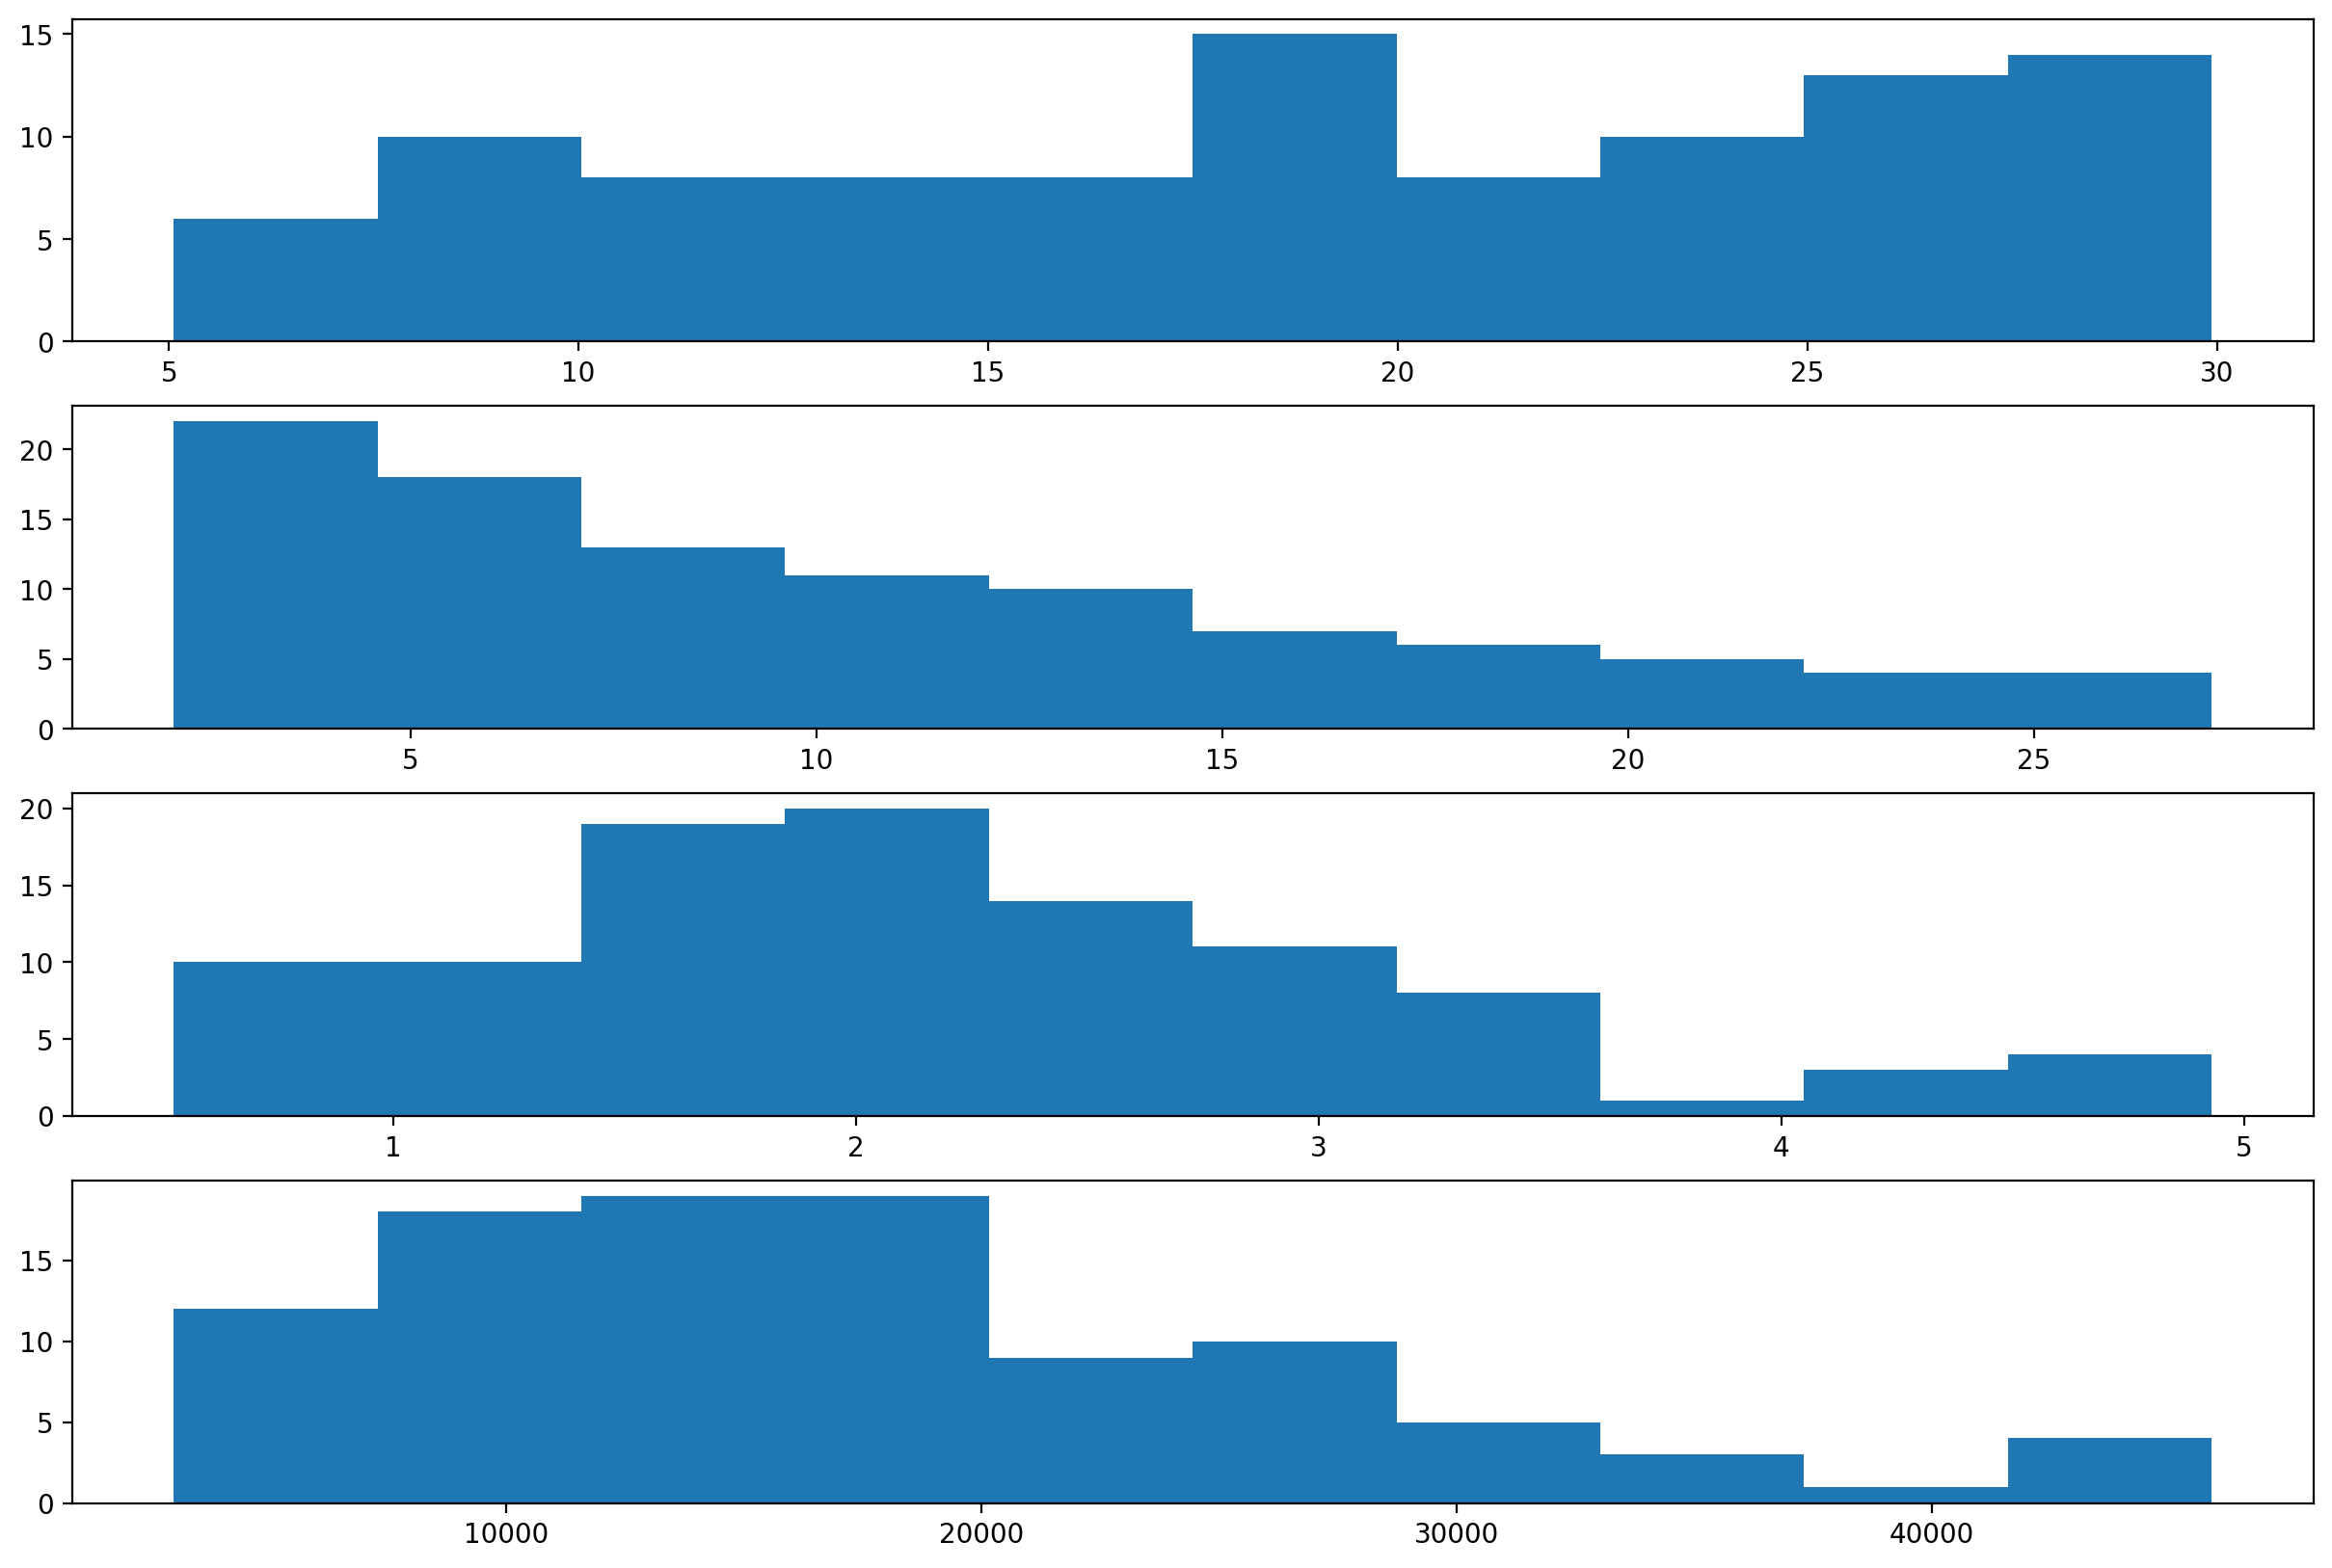

In [3]:
fig, axs = plt.subplots(4, 1, figsize=(15,10))
axs[0].hist(m1binaries)
axs[1].hist(m2binaries)
axs[2].hist(zbinaries)
axs[-1].hist(dlbinaries)

fig.show()

We instantiate detectors corresponding to Ligo Hanford and Ligo Livingston, and plot their 04-High PSD curves:

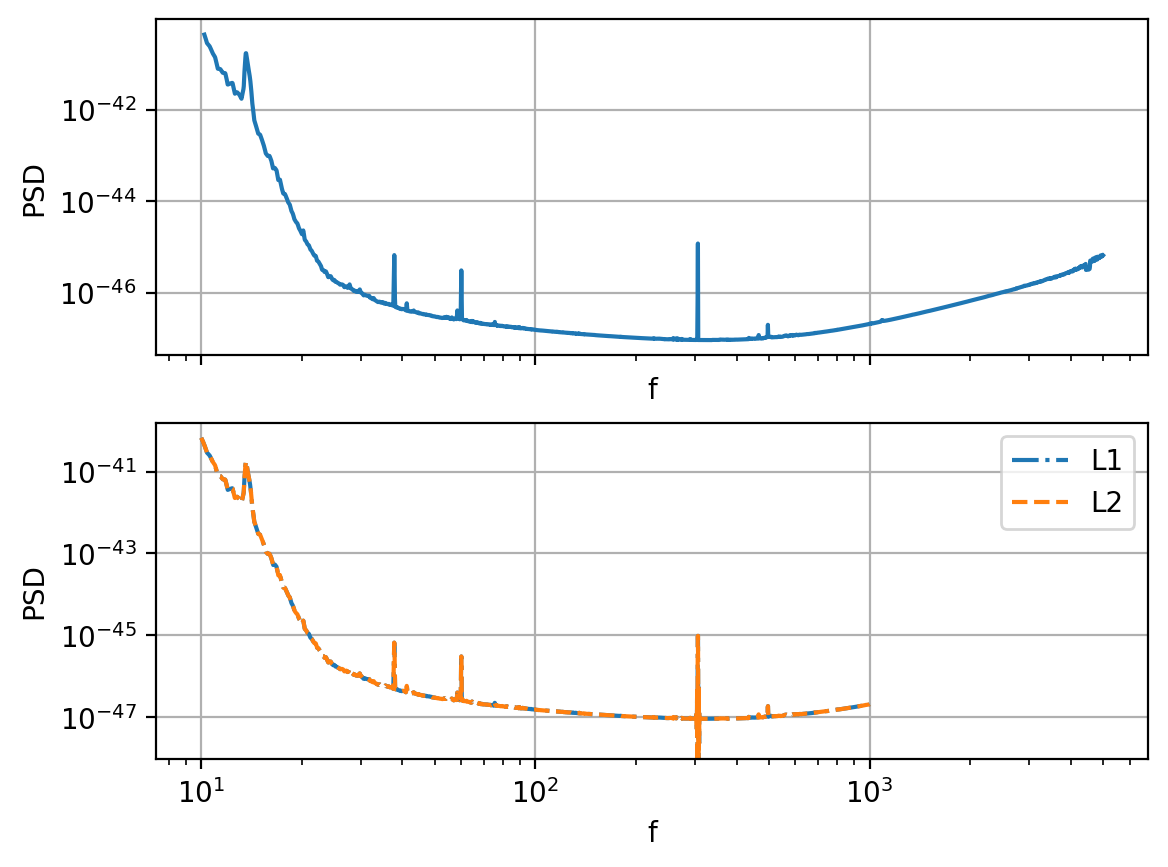

In [4]:
ligo_h_position = DetectorPosition(*DetectorCoordinates.LIGO_HANFORD.value)
ligo_h = Detector(DetectorCoordinates.LIGO_HANFORD.name, ligo_h_position, DetectorSensitivities.LIGO_O4_HIGH)

ligo_l_position = DetectorPosition(*DetectorCoordinates.LIGO_LIVINGSTON.value)
ligo_l = Detector(DetectorCoordinates.LIGO_LIVINGSTON.name, ligo_l_position, DetectorSensitivities.LIGO_O4_HIGH)

logfmin, logfmax, fsize = 1, 3, 3000
fmin, fmax = np.exp(logfmin), np.exp(logfmax)
f = np.logspace(logfmin, logfmax, num=fsize)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(ligo_h._f, ligo_h._sn)
ax[1].plot(f, ligo_h.psd(f), label="L1", ls='-.')
ax[1].plot(f, ligo_l.psd(f), label="L2", ls='--')
ax[0].set_xlabel('f')
ax[1].set_xlabel('f')
ax[0].set_ylabel('PSD')
ax[1].set_ylabel('PSD')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[0].grid()
ax[1].grid()
ax[1].legend()
fig.show()

Generating event instances for each blob of parameters:

In [5]:
events = []
for i in range(nbinaries):
    m1, m2 = m1binaries[i], m2binaries[i]
    zi = zbinaries[i]
    dl = dlbinaries[i]
    position = Spherical3DCoordinates(theta[i], phi[i])
    event = GWEvent(zi, dl, m1, m2, position, psi[i], iota[i])
    events.append(event)

## Waveform comparison

In this section, we compare the implementation of the TaylorF2 waveform approximant between `GWDALI` and our code. We first select one event at random to perform a visual analysis of the waveform's phase, amplitude, and polarizations:

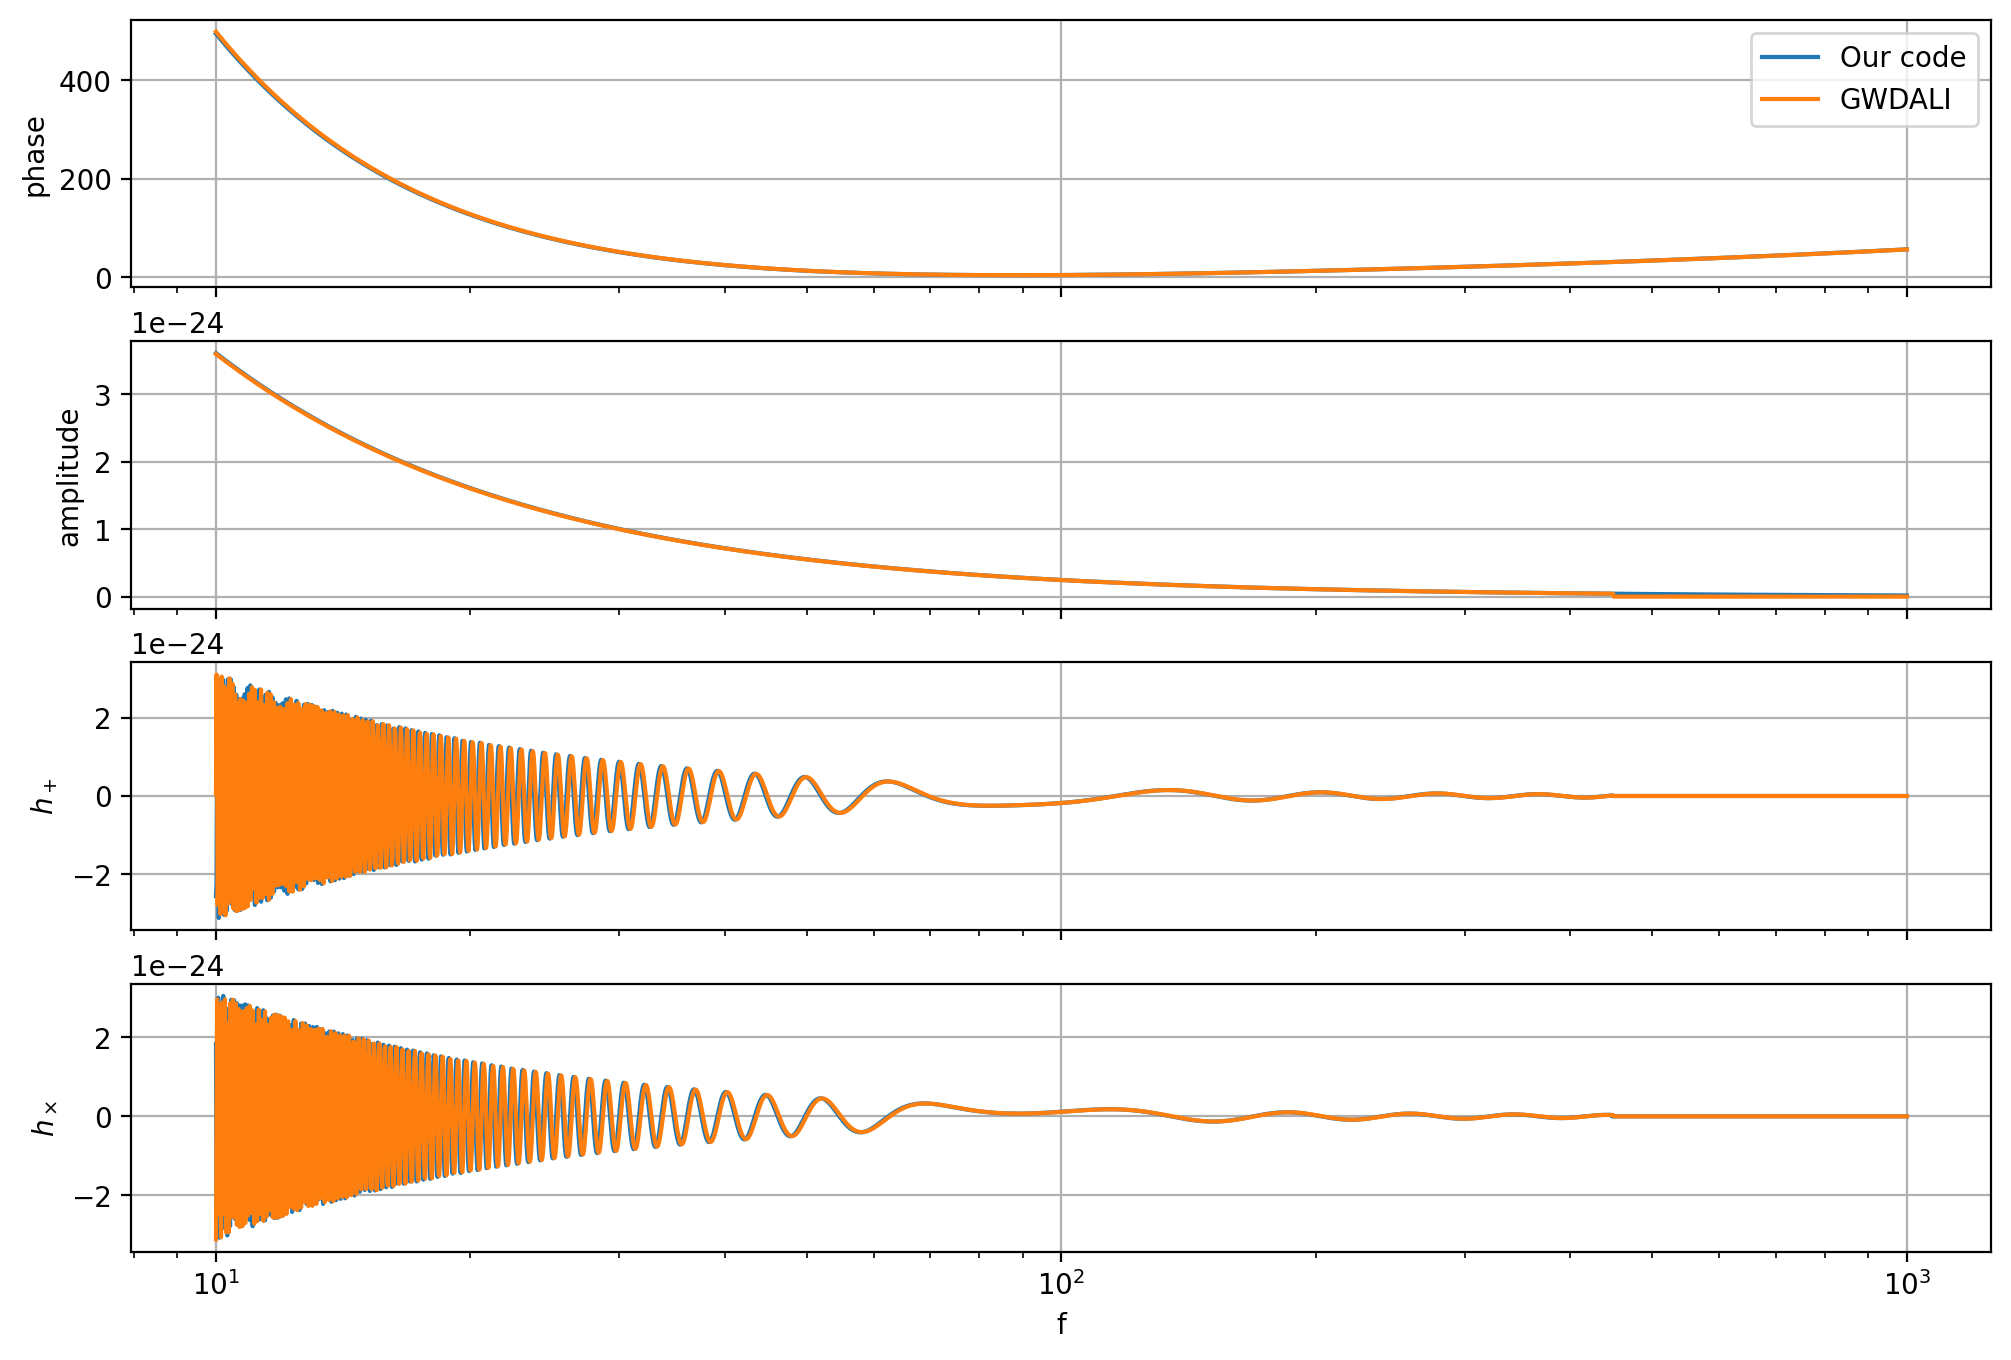

In [6]:
ibin = np.random.choice(nbinaries)
gw = events[ibin]
waveform = TaylorF2(gw)
params = gw.to_gwdali_dict()

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

# Phase comparison
ax = axs[0]
ax.plot(f, waveform.phase_expansion(f), label='Our code')
ax.plot(f, gwdali.lib.Waveforms.GW_Phase_TaylorF2(gw.m1d, gw.m2d, f), label='GWDALI')
ax.set_ylabel('phase')
ax.legend()

# Amplitude comparison
ax = axs[1]
ax.plot(f, waveform.amplitude(f), label='Our code')
ax.plot(f, gwdali.lib.Waveforms.GW_Amplitude(gw.m1d, gw.m2d, gw.dl, f), label='GWDALI')
ax.set_ylabel('amplitude')

# Polarizations comparison
axplus, axcross = axs[2:]
hplus, hcross = waveform.polarizations(f)
#gwdali_hplus, gwdali_hcross, _ = gwdali.lib.Waveforms.Waveform_TaylorF2(gw.m1d, gw.m2d, gw.iota, gw.dl, 0, 0, f)
gwdali_hplus, gwdali_hcross, _ = gwdali.lib.Diff_Signal_Tensors.GW_Polarizations(params, f, 'TaylorF2_py')
axplus.plot(f, hplus, label='Our code')
axplus.plot(f, gwdali_hplus, label='GWDALI')
axplus.set_ylabel(r'$h_+$')
axcross.plot(f, hcross, label='Our code')
axcross.plot(f, gwdali_hcross, label='GWDALI')
axcross.set_ylabel(r'$h_\times$')
axcross.set_xlabel('f')

for ax in axs:
    ax.grid()
    ax.set_xscale('log')

fig.show()

## Strain and PSD comparison

Next, we compare the strain and PSD for the same array of detectors in both implementations:

L1 pattern function: F+=-0.3, Fx=-0.3
L2 pattern function: F+=-0.0, Fx=-0.2


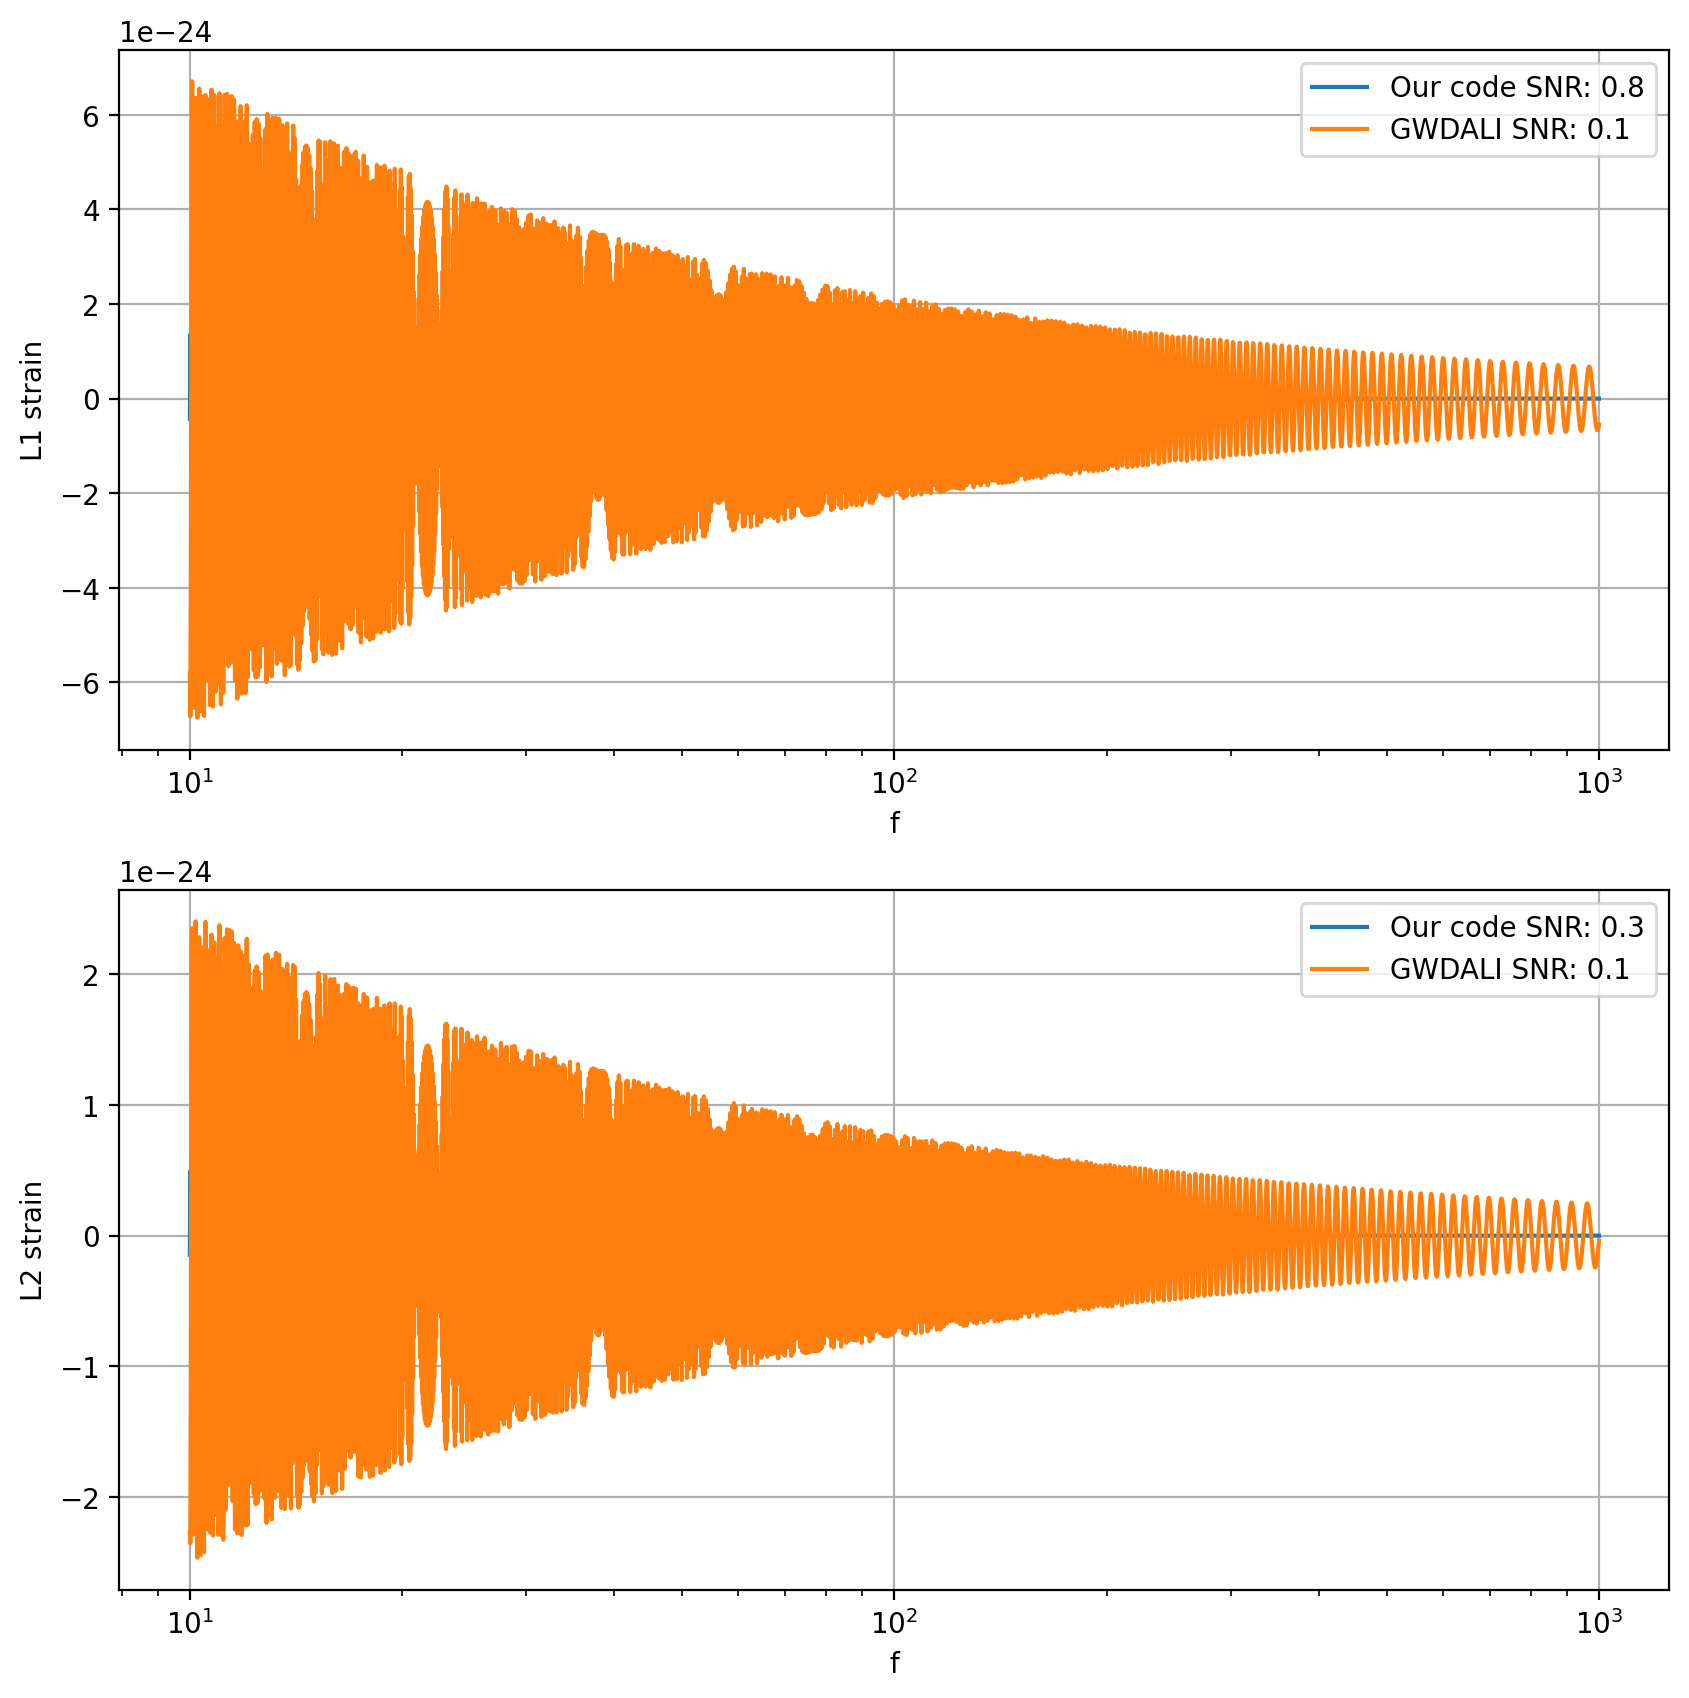

In [12]:
# Strain
ligo_h_strain = ligo_h.strain(waveform, f)
ligo_l_strain = ligo_l.strain(waveform, f)

# SNR
ligo_h_snr = ligo_h.optimal_snr(ligo_h_strain, f)
ligo_l_snr = ligo_l.optimal_snr(ligo_l_strain, f)
net_snr = network_snr(ligo_h_snr, ligo_l_snr)

# Detectors
detectors = [det.value.to_dict() for det in GWDALIDetectors]
l1pos = ligo_h.position
l2pos = ligo_l.position
alpha, beta = gw.position.angles
l1fp, l1fx = l1pos.pattern_function(alpha, beta, gw.psi, gw.iota)
l2fp, l2fx = l2pos.pattern_function(alpha, beta, gw.psi, gw.iota)
#l1f_gwdali = gwdali.lib.Diff_Signal_Tensors.Pattern_Func(l1pos.phi, l1pos.theta, l1pos.rot2rad, l1pos.shape2rad)
#l2f_gwdali = gwdali.lib.Diff_Signal_Tensors.Pattern_Func(l2pos.phi, l2pos.theta, l2pos.rot2rad, l2pos.shape2rad)
print(f"L1 pattern function: F+={l1fp:.1f}, Fx={l1fx:.1f}")
print(f"L2 pattern function: F+={l2fp:.1f}, Fx={l2fx:.1f}")

# GWDALI
params = gw.to_gwdali_dict()
_, strain, snr, _ = gwdali.get_strain_snr(params, detectors, approximant="TaylorF2_py", fmin=fmin, fmax=fmax, fsize=fsize)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Strain
axs[0].plot(f, ligo_h_strain, label=f'Our code SNR: {ligo_h_snr:.1f}')
axs[0].plot(f, strain[0], label=f'GWDALI SNR: {snr[0]:.1f}')
axs[0].set_ylabel('L1 strain')
axs[1].plot(f, ligo_l_strain, label=f'Our code SNR: {ligo_l_snr:.1f}')
axs[1].plot(f, strain[1], label=f'GWDALI SNR: {snr[1]:.1f}')
axs[1].set_ylabel('L2 strain')
for ax in axs:
    ax.set_xlabel('f')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.grid()
    ax.legend()


fig.show()

# cutoff = f < 4 * waveform.f_isco
# plt.plot(f[cutoff], ligo_h_signal[cutoff], label=f'L1 SNR: {ligo_h_snr:.2f}', ls='-')
# plt.plot(f[cutoff], ligo_l_signal[cutoff], label=f'L2 SNR: {ligo_l_snr:.2f}', ls='-.')
# plt.axvline(4 * waveform.f_isco)
# plt.xscale('log')
# plt.xlabel('f')
# plt.ylabel('h')
# plt.title(f"m1={event.m1s:.0f} Msun, m2={event.m2s:.0f} Msun, dL = {event.dl:.0f} Mpc")
# plt.legend()
# plt.grid()
# plt.show()

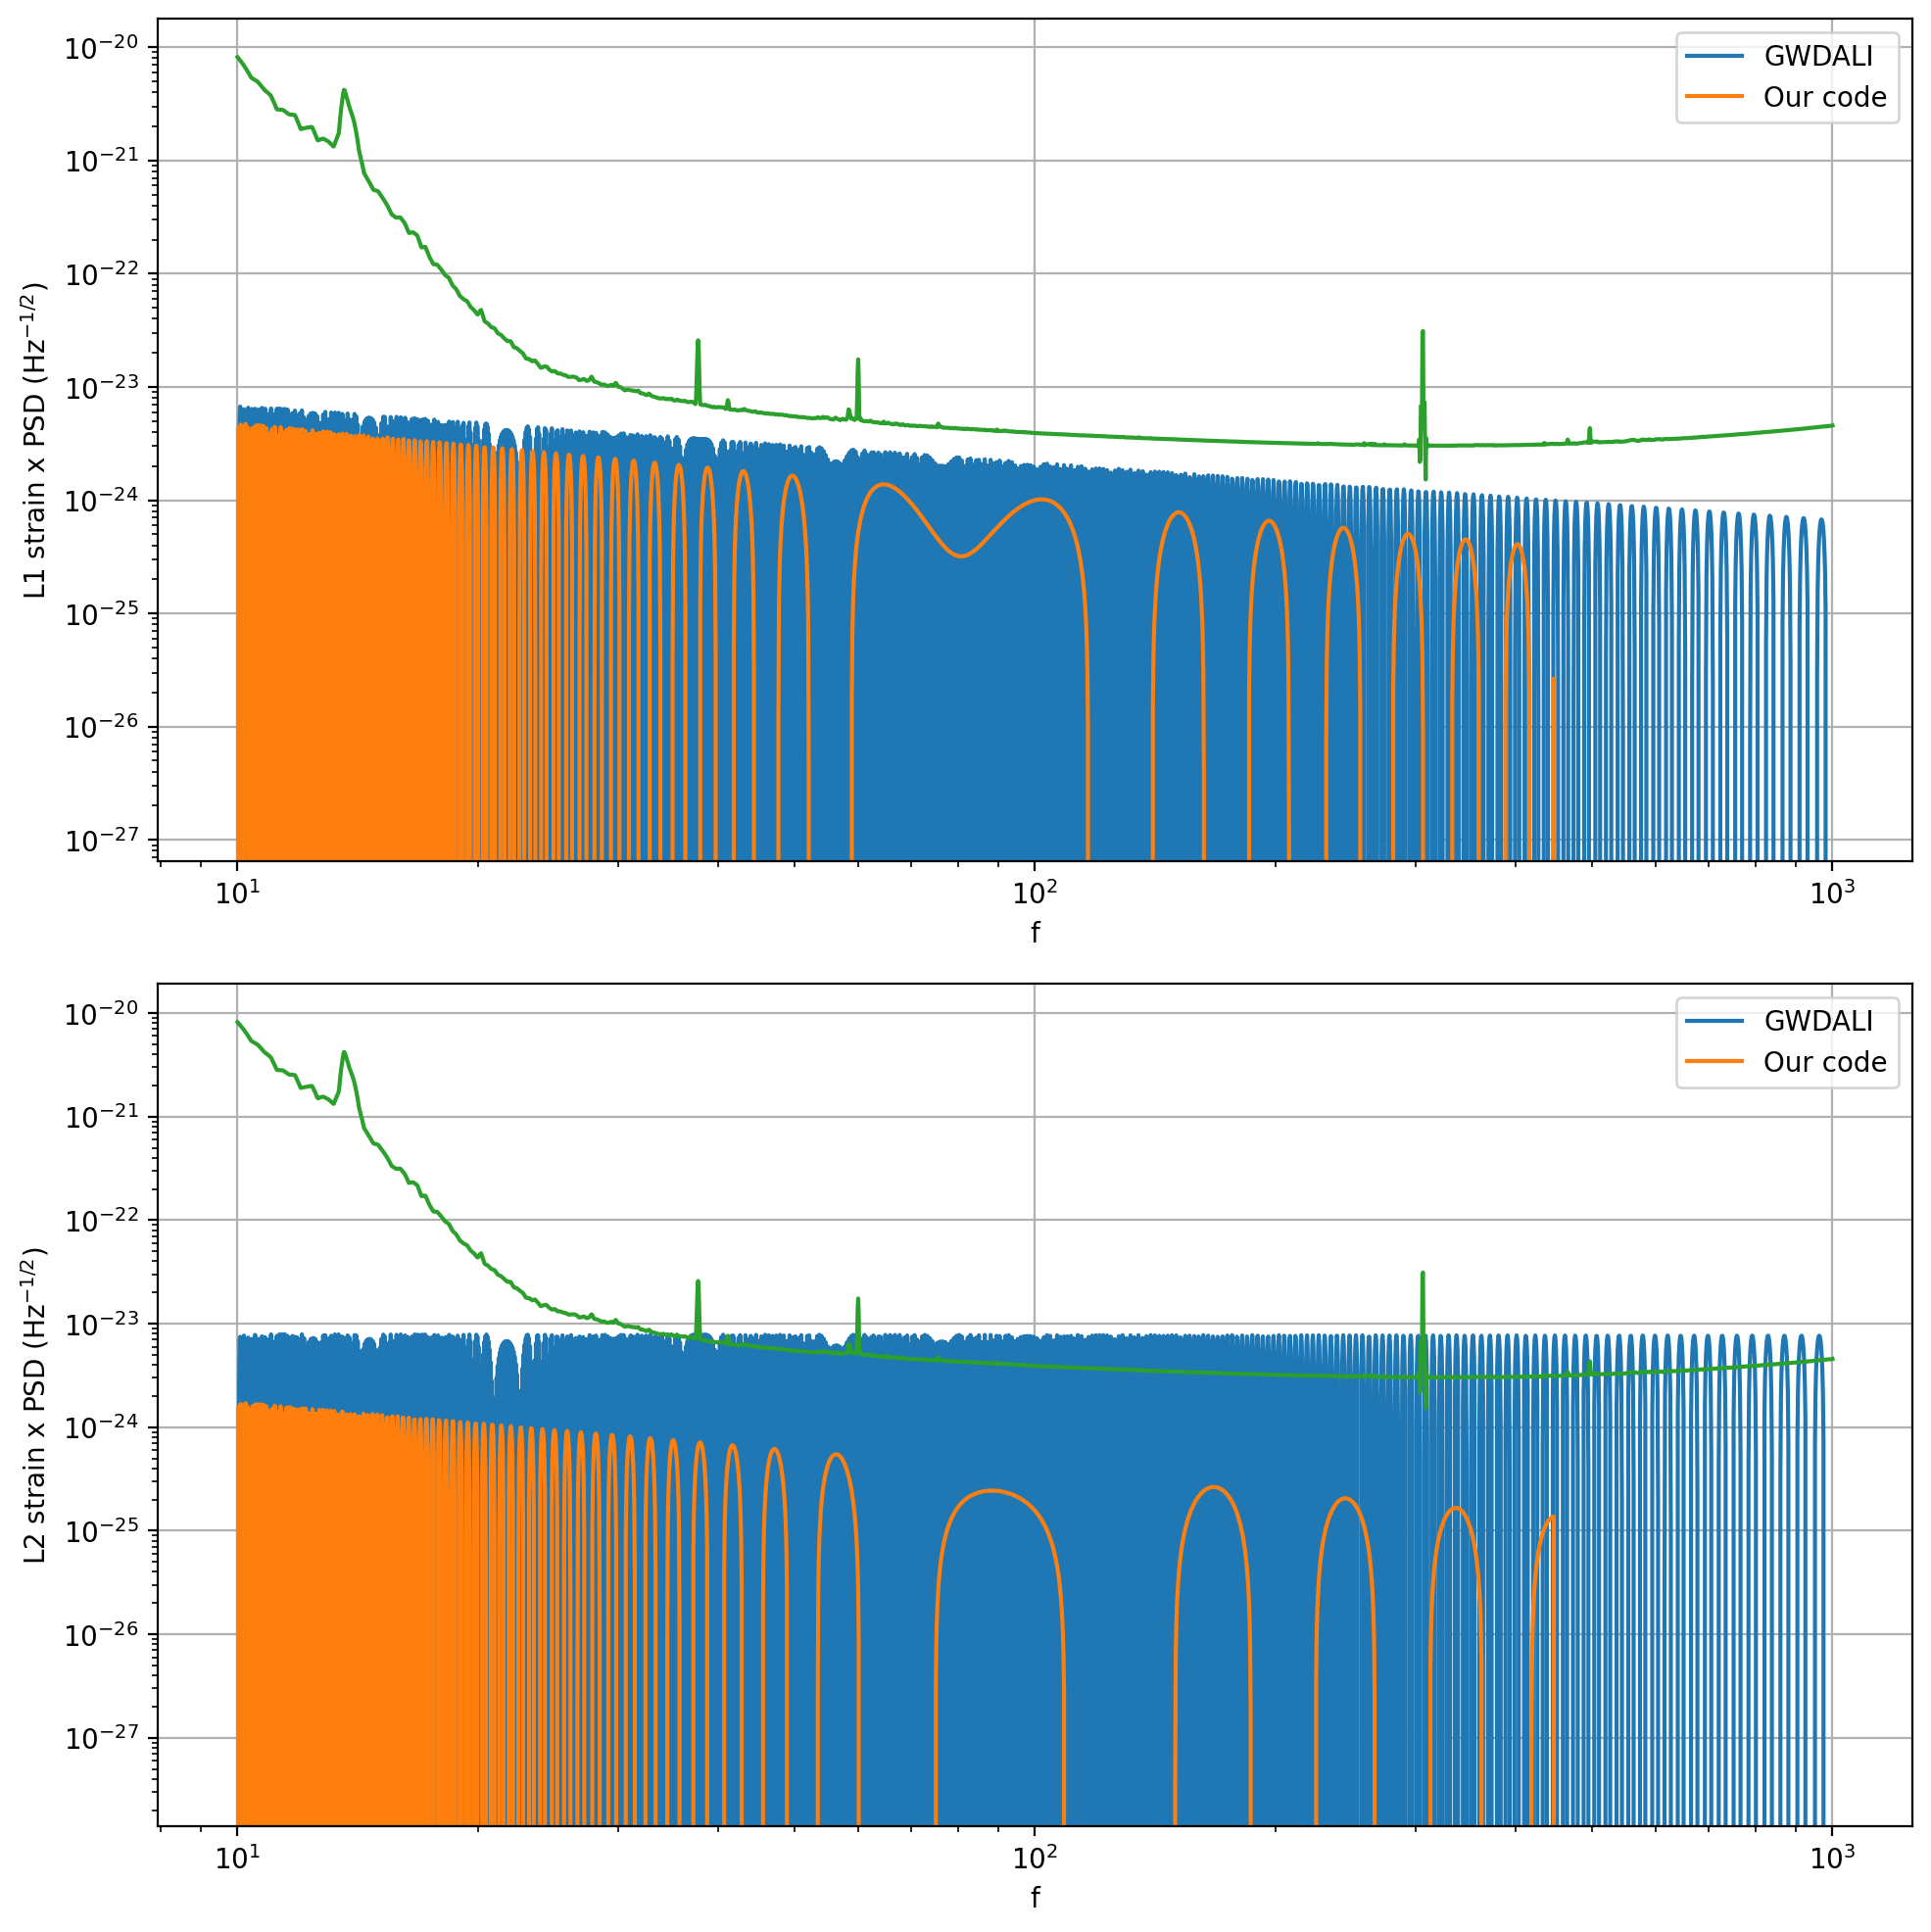

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Strain
axs[0].plot(f, strain[0], label=f'GWDALI')
axs[0].plot(f, np.sqrt(f) * ligo_h_strain, label=f'Our code')
axs[0].plot(f, np.sqrt(ligo_h.psd(f)))
axs[0].set_ylabel(r'L1 strain x PSD ($\text{Hz}^{-1/2}$)')
axs[1].plot(f, np.sqrt(f) * strain[1], label=f'GWDALI')
axs[1].plot(f, np.sqrt(f) * ligo_l_strain, label=f'Our code')
axs[1].plot(f, np.sqrt(ligo_l.psd(f)))
axs[1].set_ylabel(r'L2 strain x PSD ($\text{Hz}^{-1/2}$)')
for ax in axs:
    ax.set_xlabel('f')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

In what follows, we will generate injected signals from the priors above using the `GWDALI` package:

In [8]:
# # Adapted from https://gwdali.readthedocs.io/en/latest/usage.html
# free_params = ['m1', 'm2', 'DL', 'RA', 'Dec', 'iota']



# # Detectors
# detectors = [det.value.to_dict() for det in GWDALIDetectors]

# pprint(params)

# # inference = gwdali.GWDALI(
# #     Detection_Dict=params,
# #     FreeParams=free_params,
# #     fmin=fmin,
# #     fmax=fmax,
# #     fsize=fsize,
# #     detectors=detectors,
# #     approximant='TaylorF2_py',
# #     dali_method='Fisher',
# #     run_sampler=False,
# #     hide_info=True
# # )
# _, strain, snr, _ = gwdali.get_strain_snr(params, detectors, approximant="TaylorF2_py", fmin=fmin, fmax=fmax, fsize=fsize)
# plt.plot(f[cutoff], strain[0][cutoff], label=f'L1 SNR: {snr[0]:.2f}', ls='-')
# plt.plot(f[cutoff], strain[1][cutoff], label=f'L2 SNR: {snr[1]:.2f}', ls='-.')
# plt.axvline(waveform.f_isco)
# plt.xscale('log')
# plt.xlabel('f')
# plt.ylabel('h')
# plt.title(f"m1={event.m1s:.0f} Msun, m2={event.m2s:.0f} Msun, dL = {event.dl:.0f} Mpc")
# plt.legend()
# plt.grid()
# plt.show()

In [9]:
# samples = inference['Samples']
# corner(samples, labels=free_params, truths=[params[free_param] for free_param in free_params])